Episode: 500, Total Steps: 4431, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.01
************************************************** 285.0
Episode: 1000, Total Steps: 8940, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.00
************************************************** 781.0
Episode: 1500, Total Steps: 13451, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.00
************************************************** 1277.0
Episode: 2000, Total Steps: 17946, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.00
************************************************** 1776.0
Episode: 2500, Total Steps: 22454, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.00
************************************************** 2272.0
Episode: 3000, Total Steps: 26958, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.00
************************************************** 2770.0
Episode: 3500, Total Steps: 31465, Ep Step: 9, Raw Reward: 1.00, Epsilon: 0.00
************************************************** 3267.0
Episode: 4000, Total Steps: 35969, Ep Step: 9,

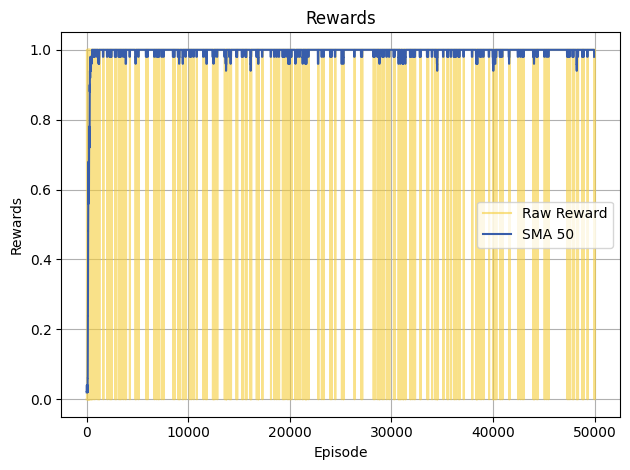

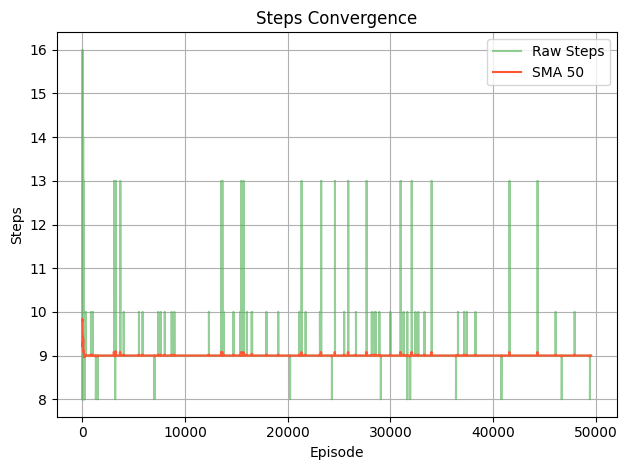

In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from agent.base_agent import BaseAgent
from utils import seed_everything
import pandas as pd

# Q-Learning Agent Class inheriting from Agent
df=pd.DataFrame(columns=[i for i in range(64)])
def df_append(df, new_data):
    """
    Append new data to a DataFrame, keeping only three decimal places.
    """
    # 保留三位小数
    new_data = np.round(new_data, 4)
    new_row = pd.DataFrame([new_data], columns=df.columns)
    df = pd.concat([df, new_row], ignore_index=True)
    return df




class QLearningAgent(BaseAgent):
    def __init__(self, env, hyperparams):
        """
        Q-Learning Agent class for interacting with the environment and learning
        """
        super(QLearningAgent, self).__init__(env, hyperparams)
        self.Q_table = np.zeros((self.state_dim, self.num_actions))
        # 若要启用初始化,则运行下一行代码
        # self.initialize_q_values_with_penalty(env, env.unwrapped.desc)
        # Additional hyperparameters
        self.learning_rate = hyperparams['learning_rate']
        self.discount = hyperparams['discount_factor']
        self.epsilon = hyperparams['epsilon_max']
        self.epsilon_min = hyperparams['epsilon_min']
        self.epsilon_decay = hyperparams['epsilon_decay']


    def initialize_q_values_with_penalty(self, grid):
        q_table = np.zeros((self.state_dim, self.num_actions))  # Initial Q-table

        # Get grid dimensions
        nrows, ncols = grid.shape

        def manhattan_distance(x1, y1, x2, y2):
            return abs(x1 - x2) + abs(y1 - y2)

        goal = np.argwhere(grid == b'G')[0]  # Goal point
        ice_pits = np.argwhere(grid == b'H')
        for state in range(self.state_dim):
            row, col = state // ncols, state % ncols  # State to (row, col)
            for action in range(self.num_actions):
                next_row, next_col = row, col
                if action == 0 and col > 0:  # Left
                    next_col -= 1
                elif action == 1 and row < nrows - 1:  # Down
                    next_row += 1
                elif action == 2 and col < ncols - 1:  # Right
                    next_col += 1
                elif action == 3 and row > 0:  # Up
                    next_row -= 1
                if grid[next_row, next_col] == b'G':  # Goal
                    q_table[state, action] = 1 / 3
                elif grid[next_row, next_col] == b'H':  # Ice pit
                    q_table[state, action] = -0.01
                else:
                    dist_to_goal = manhattan_distance(next_row, next_col, goal[0], goal[1])
                    dist_to_pits = [manhattan_distance(next_row, next_col, pit[0], pit[1]) for pit in ice_pits]
                    q_table[state, action] = (1 / 3) * (1 / (1 + dist_to_goal)) - 0.01 * (
                            1 / (min(dist_to_pits, default=1000)))
        return q_table

    # 已经随机的完成了action
    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy
        """
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state, done):
        """
        Learn from a single experience using the Q-learning update rule
        """
        best_next_action = np.argmax(self.Q_table[next_state])
        td_target = reward + self.discount * self.Q_table[next_state, best_next_action] * (1 - done)
        td_error = td_target - self.Q_table[state, action]
        self.Q_table[state, action] += self.learning_rate * td_error

    def update_epsilon(self):
        """
        Update epsilon value for epsilon-greedy policy
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path):
        """
        Save the trained Q-table
        """
        np.save(path, self.Q_table)

    def load(self, path):
        """
        Load the Q-table
        """
        self.Q_table = np.load(path)

# Trainer Class
class Trainer:
    def __init__(self, env, agent, hyperparams):
        """
        Trainer class to manage training and evaluation of the agent
        """
        self.env = env
        self.agent = agent
        self.hyperparams = hyperparams
        self.reward_history = []
        self.step_history = []
        self.table=[]

    def train(self):
        """
        Train the agent for a specified number of episodes
        """
        global df
        total_steps = 0
        for episode in range(1, self.hyperparams['max_episodes'] + 1):
            state, _ = self.env.reset(seed=seed)  # Remove fixed seed
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                # Select and execute an action
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)

                # Learn from the experience
                self.agent.learn(state, action, reward, next_state, done)

                state = next_state
                # track[state]+=1
                episode_reward += reward
                step_size += 1

            self.reward_history.append(episode_reward)
            if episode_reward==1:
                self.step_history.append(step_size)  # Track steps for each episode
            total_steps += step_size
            self.agent.update_epsilon()
            # self.table.append(check_policy(self.agent.Q_table, ground_truth))
            

            # Save the model at specified intervals
            if episode % self.hyperparams['save_interval'] == 0:
                os.makedirs(self.hyperparams['model_dir'], exist_ok=True)
                self.agent.save(os.path.join(self.hyperparams['model_dir'], f'{episode}.npy'))
                print('\n~~~~~~Interval Save: Model saved.\n')

            # Print episode information at specified intervals
            if episode % self.hyperparams['print_interval'] == 0:
                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, Raw Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon:.2f}")
                print("*"*50, np.sum(self.reward_history))
                
            if episode % 100 == 0:
                df=df_append(df, self.agent.Q_table[:, [3, 0, 2, 1]].flatten())
        
        print("-"*50)

        # Plot results after training
        self.plot_training(episode)
        
        

    def test(self, max_episodes=None):
        """
        Test the trained agent for a specified number of episodes
        """
        # Load the trained Q-table
        self.agent.load(os.path.join(self.hyperparams['model_dir'], f"{self.hyperparams['train_episodes']}.npy"))
        # Set epsilon to 0 to always exploit
        self.agent.epsilon = 0.0

        if max_episodes is None:
            max_episodes = self.hyperparams['max_episodes']

        try:
            for episode in range(1, max_episodes + 1):
                state, _ = self.env.reset(seed=seed)
                done, truncation = False, False
                step_size, episode_reward = 0, 0

                while not done and not truncation:
                    # Render the environment if desired
                    if self.hyperparams['render']:
                        self.env.render()

                    # Select an action
                    action = self.agent.select_action(state)
                    next_state, reward, done, truncation, _ = self.env.step(action)
                    state = next_state
                    episode_reward += reward
                    step_size += 1

                # Print episode information
                print(f"Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")
                print("*"*50, np.sum(self.reward_history))

        finally:
            # Ensure the environment is properly closed
            self.env.close()
            print("Environment has been closed.")


    def plot_training(self, episode):
        """
        Plot the training reward history and step convergence
        """
        # Plot Rewards
        sma_window = 50  # Simple Moving Average window
        if len(self.reward_history) >= sma_window:
            sma = np.convolve(self.reward_history, np.ones(sma_window)/sma_window, mode='valid')
        else:
            sma = self.reward_history
        plt.figure()
        plt.title("Rewards")
        print(np.sum(self.reward_history))

        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=0.6)
        plt.plot(range(len(sma)), sma, label=f'SMA {sma_window}', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            os.makedirs(self.hyperparams['plot_dir'], exist_ok=True)
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'reward_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Steps Convergence
        if len(self.step_history) >= sma_window:
            sma_steps = np.convolve(self.step_history, np.ones(sma_window)/sma_window, mode='valid')
        else:
            sma_steps = self.step_history
        plt.figure()
        plt.title("Steps Convergence")
        plt.plot(self.step_history, label='Raw Steps', color='#4CAF50', alpha=0.6)
        plt.plot(range(len(sma_steps)), sma_steps, label=f'SMA {sma_window}', color='#FF5733')
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'steps_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()
        
def check_policy(Q_table, ground_truth):
    policy = np.argmax(Q_table, axis=1)
    return np.sum(policy == ground_truth)

# Main Function to Set Up and Train/Test the Model
if __name__ == "__main__":
    method_name = "q_learning"
    train_mode = True

    train_episodes = 50000
    render = not train_mode
    map_size =  4  # Start with 4x4 map
    seed =10
    
    # ground_truth=[2, 3, 0, 0, 2, 0, 3, 0, 1, 0, 0, 0, 0, 2, 1, 0]
    
    # Config paths and hyperparameters
    config = {
        "train_mode": train_mode,
        "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
        "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/', 
        "save_interval": 5000,
        "print_interval": 500,
        "learning_rate": 0.001,
        "discount_factor": 0.92,
        "max_episodes": train_episodes if train_mode else 10,
        "train_episodes": train_episodes,
        "max_steps": 1000,
        "render": render,
        "epsilon_max": 0.995 if train_mode else -1,
        "epsilon_min": 0.001,
        "epsilon_decay": 0.99,
        "map_size": map_size,
        "render_fps": 161,
    }
    # config = {
    #     "train_mode": train_mode,
    #     "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
    #     "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/', 
    #     "save_interval": 5000,
    #     "print_interval": 500,
    #     "learning_rate": 0.05,
    #     "discount_factor": 0.99,
    #     "max_episodes": train_episodes if train_mode else 10,
    #     "train_episodes": train_episodes,
    #     "max_steps": 1000,
    #     "render": render,
    #     "epsilon_max": 1.0 if train_mode else -1,
    #     "epsilon_min": 0.1,
    #     "epsilon_decay": 0.9999,
    #     "map_size": map_size,
    #     "render_fps": 6,
    # }
    # Set seed
    seed_everything(seed)

    # Create environment
    env = gym.make(
        'FrozenLake-v1',
        map_name=f"{config['map_size']}x{config['map_size']}",
        is_slippery=True,
        max_episode_steps=config['max_steps'],
        render_mode="human" if config['render'] else None
    )
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']

    # Create agent and trainer
    agent = QLearningAgent(env, config)
    trainer = Trainer(env, agent, config)

    # Train or test
    if config['train_mode']:
        trainer.train()
    else:
        trainer.test()
